In [1]:
%load_ext rpy2.ipython

In [184]:
%%R
library(dplyr)
library(tidyr)
library(broom)
library(ggplot2)
library(magrittr)

In [206]:
%%R
comparisons = list(c("Low", "High"), 
                   c("Low", "Spruce Fir"), 
                   c("High", "Spruce Fir"))

sd = read.csv("../../data/HB/HB_Noxide.csv", stringsAsFactors = FALSE) %>%
    select(Sample.Name, Treatment, Elevation, Depth)

In [350]:
!head ../../data/HB/nirK_clades_HB.csv

In [353]:
%%R
df.nirK %>%
    head

Source: local data frame [6 x 7]

    clade Sample.Name count Treatment Elevation   Depth   rel.count
    (chr)       (chr) (int)     (chr)     (chr)   (chr)       (dbl)
1 Clade 1        CJ01    10        Ca      High Mineral 0.042553191
2 Clade 2        CJ01    18        Ca      High Mineral 0.076595745
3 Clade 3        CJ01     0        Ca      High Mineral 0.000000000
4 Clade 4        CJ01     1        Ca      High Mineral 0.004255319
5 Clade 5        CJ01     7        Ca      High Mineral 0.029787234
6 Clade 6        CJ01   106        Ca      High Mineral 0.451063830


In [249]:
%%R
lines = readLines("../../data/HB/Nos_clades_HB.csv")
skip_second = lines[-2]
df.Nos = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE)
colnames(df.Nos)[1] = "clade"

df.Nos %<>%
    gather(Sample.Name, count, -clade) %>%
    left_join(sd) %>%
    group_by(Sample.Name) %>%
    mutate(rel.count = count / sum(count)) %>%
    ungroup()

lines = readLines("../../data/HB/nirK_clades_HB.csv")
skip_second = lines[-2]
df.nirK = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE)
colnames(df.nirK)[1] = "clade"

df.nirK %<>%
    gather(Sample.Name, count, -clade) %>%
    left_join(sd) %>%
    group_by(Sample.Name) %>%
    mutate(rel.count = count / sum(count)) %>%
    ungroup()

lines = readLines("../../data/HB/qNor_clades_HB.csv")
skip_second = lines[-2]
df.qNor = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE)
colnames(df.qNor)[1] = "clade"

df.qNor %<>%
    gather(Sample.Name, count, -clade) %>%
    left_join(sd) %>%
    group_by(Sample.Name) %>%
    mutate(rel.count = count / sum(count)) %>%
    ungroup()

In [250]:
%%R
reg = function (comp, df) {
    comp.str = paste(comp, collapse = " v. ")
    df %>% 
        group_by(clade) %>%
        filter(Elevation %in% comp) %>%
        mutate(Elevation = factor(Elevation, levels = comp)) %>%
        do(fit = glm(rel.count ~ Elevation, data = ., family = quasibinomial())) %>%
        tidy(fit) %>%
        filter(term != "(Intercept)") %>%
        mutate(comp.str = comp.str)
}

In [304]:
%%R
reg.nirK = plyr::ldply(comparisons, reg, df = df.nirK) 
reg.nirK$gene = "nirK"

reg.qNor = plyr::ldply(comparisons, reg, df = df.qNor) 
reg.qNor$gene = "qNor"

reg.Nos = plyr::ldply(comparisons, reg, df = df.Nos) 
reg.Nos$gene = "Nos"

reg.all = rbind(reg.nirK, reg.qNor, reg.Nos)
reg.all$gene.clade = with(reg.all, paste(gene, clade, sep = "."))

ord = reg.all %>%
    arrange(comp.str, gene, log(p.value)) %>%
    extract2("gene.clade")

reg.all$gene.clade = factor(reg.all$gene.clade, levels = ord)

reg.all %>% head

     clade          term   estimate std.error  statistic     p.value
1  Clade 1 ElevationHigh  1.1044594 0.3030613  3.6443432 0.004504279
2 Clade 10 ElevationHigh -0.2174461 0.2582282 -0.8420696 0.419431740
3 Clade 11 ElevationHigh  0.9861160 0.5851618  1.6852024 0.122850484
4 Clade 12 ElevationHigh  0.7799436 1.1959502  0.6521539 0.529006184
5 Clade 13 ElevationHigh  1.4759742 0.6678770  2.2099490 0.051565134
6 Clade 14 ElevationHigh  0.9854004 0.5597645  1.7603840 0.108835935
     comp.str gene    gene.clade
1 Low v. High nirK  nirK.Clade 1
2 Low v. High nirK nirK.Clade 10
3 Low v. High nirK nirK.Clade 11
4 Low v. High nirK nirK.Clade 12
5 Low v. High nirK nirK.Clade 13
6 Low v. High nirK nirK.Clade 14


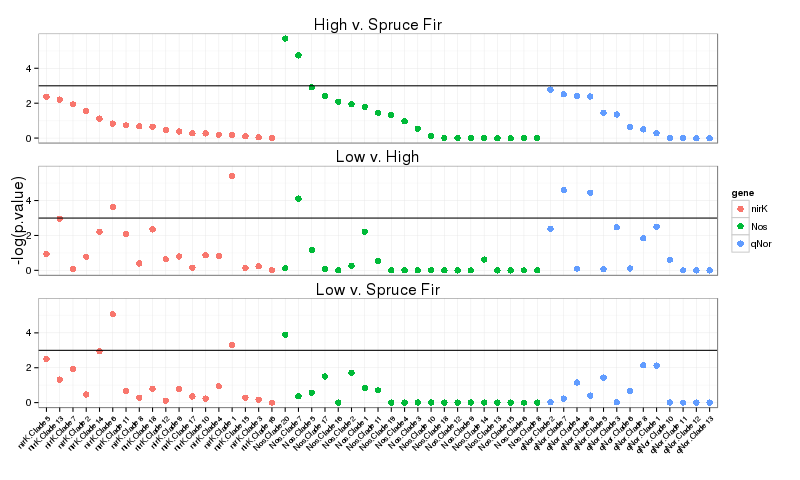

In [316]:
%%R -w 800
p = ggplot(reg.all, aes(x = gene.clade, y = -log(p.value), color = gene))

p = p + facet_wrap(~comp.str, ncol = 1)

p = p + geom_point(size = 3)

p = p + theme_bw()

p = p + labs(x = "")

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
              axis.title = element_text(size = 16),
              strip.background = element_blank(),
              strip.text = element_text(size = 16))

p = p + geom_hline(yintercept = -log(0.05))

p

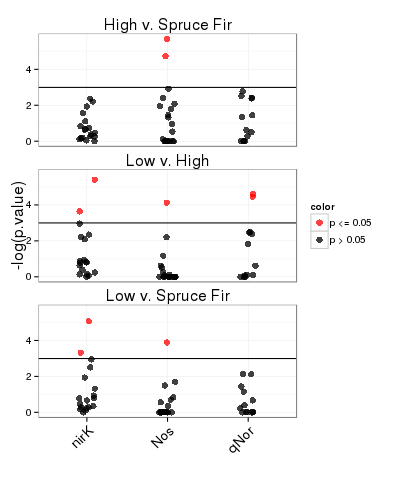

In [347]:
%%R -w 400
reg.all$color = with(reg.all, ifelse(p.value <= 0.05, "p <= 0.05", "p > 0.05"))

p = ggplot(reg.all, aes(x = gene, y = -log(p.value), color = color))

p = p + facet_wrap(~comp.str, ncol = 1)

p = p + geom_point(size = 3, alpha = 0.75, position = position_jitter(h = 0, w = 0.10))

p = p + theme_bw()

p = p + labs(x = "")

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
              axis.title = element_text(size = 16),
              strip.background = element_blank(),
              strip.text = element_text(size = 16))

p = p + geom_hline(yintercept = -log(0.05))

p = p + scale_color_manual(values = c("red", "black"))

p

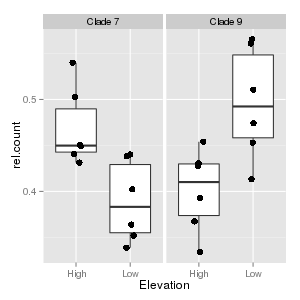

In [328]:
%%R -h 300 -w 300
d = df.qNor %>%
    filter(clade %in% c("Clade 7", "Clade 9")) %>%
    filter(Elevation %in% c("Low", "High"))

p = ggplot(d, aes(x = Elevation, y = rel.count))

p = p + facet_wrap(~clade)

p = p + geom_boxplot()

p = p + geom_point(position = position_jitter(h = 0, w = 0.10), size = 3)

p

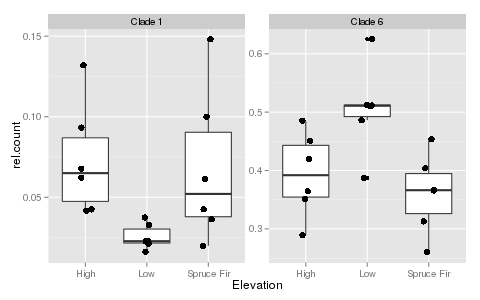

In [329]:
%%R -h 300
d = df.nirK %>%
    filter(clade %in% c("Clade 1", "Clade 6")) #%>%
    #filter(Elevation %in% c("Low", "High"))

p = ggplot(d, aes(x = Elevation, y = rel.count))

p = p + facet_wrap(~clade, scales = "free_y")

p = p + geom_boxplot()

p = p + geom_point(position = position_jitter(h = 0, w = 0.10), size = 3)

p

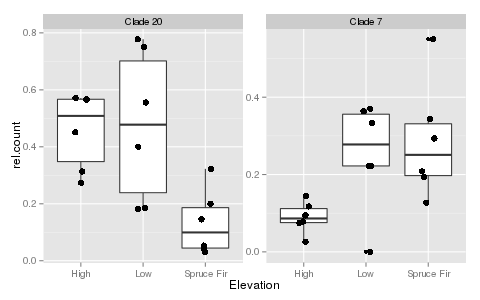

In [345]:
%%R -h 300
d = df.Nos %>%
    filter(clade %in% c("Clade 20", "Clade 7")) #%>%
    #filter(Elevation %in% c("Low", "High"))

p = ggplot(d, aes(x = Elevation, y = rel.count))

p = p + facet_wrap(~clade, scales = "free_y")

p = p + geom_boxplot()

p = p + geom_point(position = position_jitter(h = 0, w = 0.10), size = 3)

p

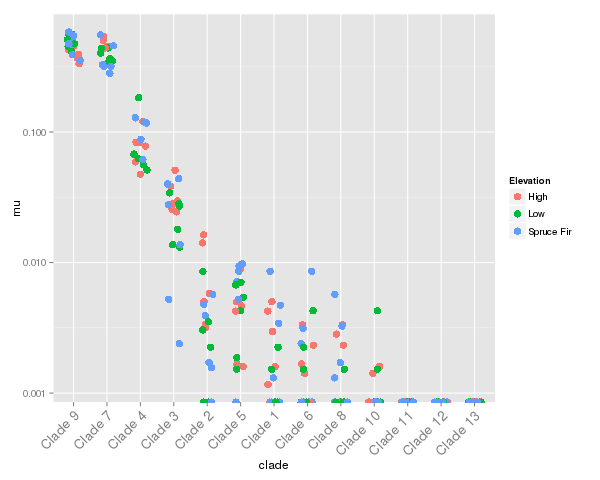

In [205]:
%%R -w 600
sd = read.csv("../../data/HB/HB_Noxide.csv", stringsAsFactors = FALSE) %>%
    select(Sample.Name, Treatment, Elevation, Depth)

lines = readLines("../../data/HB/qNor_clades_HB.csv")
skip_second = lines[-2]
df = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE)
colnames(df)[1] = "clade"

df %<>%
    gather(Sample.Name, count, -clade) %>%
    left_join(sd)

d = df %>%
    group_by(Sample.Name) %>%
    mutate(rel.count = count / sum(count)) %>%
    group_by(clade, Sample.Name) %>%
    summarize(mu = mean(rel.count)) %>% 
    group_by(Sample.Name) %>%
    mutate(R = rank(desc(mu), ties.method = "random")) %>% {
        ord = group_by(., clade) %>%
        summarize(max.mu = max(mu)) %>%
        arrange(desc(max.mu)) %>%
        extract2("clade")
        .$clade = factor(.$clade, levels = ord)
        .
    } %>%
    left_join(sd)

p = ggplot(d, aes(x = clade, y = mu, group = Sample.Name, color = Elevation))

p = p + geom_point(position = position_jitter(h = 0, w = 0.20), size = 3.5)

p = p + scale_y_log10()

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14))

p

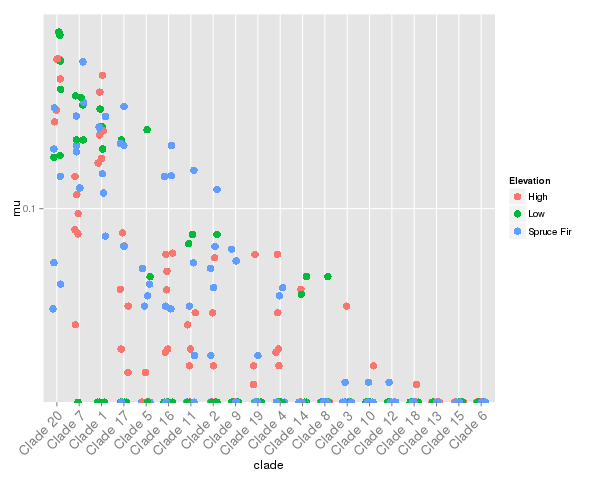

In [348]:
%%R -w 600
sd = read.csv("../../data/HB/HB_Noxide.csv", stringsAsFactors = FALSE) %>%
    select(Sample.Name, Treatment, Elevation, Depth)

lines = readLines("../../data/HB/Nos_clades_HB.csv")
skip_second = lines[-2]
df = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE)
colnames(df)[1] = "clade"

df %<>%
    gather(Sample.Name, count, -clade) %>%
    left_join(sd)

d = df %>%
    group_by(Sample.Name) %>%
    mutate(rel.count = count / sum(count)) %>%
    group_by(clade, Sample.Name) %>%
    summarize(mu = mean(rel.count)) %>% 
    group_by(Sample.Name) %>%
    mutate(R = rank(desc(mu), ties.method = "random")) %>% {
        ord = group_by(., clade) %>%
        summarize(max.mu = max(mu)) %>%
        arrange(desc(max.mu)) %>%
        extract2("clade")
        .$clade = factor(.$clade, levels = ord)
        .
    } %>%
    left_join(sd)

p = ggplot(d, aes(x = clade, y = mu, group = Sample.Name, color = Elevation))

p = p + geom_point(position = position_jitter(h = 0, w = 0.20), size = 3.5)

p = p + scale_y_log10()

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14))

p

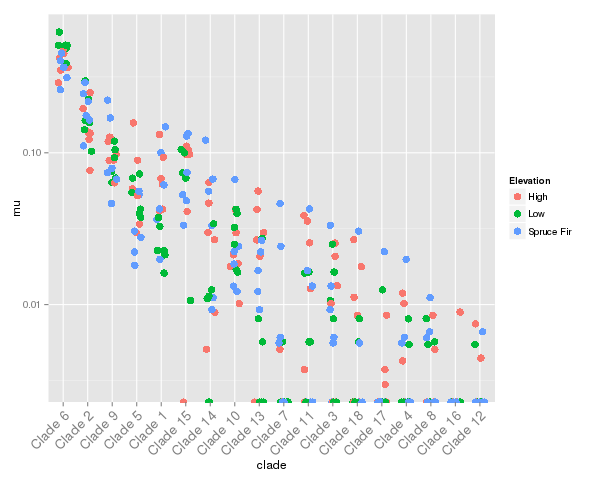

In [349]:
%%R -w 600
sd = read.csv("../../data/HB/HB_Noxide.csv", stringsAsFactors = FALSE) %>%
    select(Sample.Name, Treatment, Elevation, Depth)

lines = readLines("../../data/HB/nirK_clades_HB.csv")
skip_second = lines[-2]
df = read.csv(textConnection(skip_second), header = TRUE, stringsAsFactors = FALSE)
colnames(df)[1] = "clade"

df %<>%
    gather(Sample.Name, count, -clade) %>%
    left_join(sd)

d = df %>%
    group_by(Sample.Name) %>%
    mutate(rel.count = count / sum(count)) %>%
    group_by(clade, Sample.Name) %>%
    summarize(mu = mean(rel.count)) %>% 
    group_by(Sample.Name) %>%
    mutate(R = rank(desc(mu), ties.method = "random")) %>% {
        ord = group_by(., clade) %>%
        summarize(max.mu = max(mu)) %>%
        arrange(desc(max.mu)) %>%
        extract2("clade")
        .$clade = factor(.$clade, levels = ord)
        .
    } %>%
    left_join(sd)

p = ggplot(d, aes(x = clade, y = mu, group = Sample.Name, color = Elevation))

p = p + geom_point(position = position_jitter(h = 0, w = 0.20), size = 3.5)

p = p + scale_y_log10()

p = p + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 14))

p